## Analysis of 1st day in the RCF study
Checking amygdala activation in the CS+US condition of the task
- masking amygdala
- avergaing activation
- plot

In [1]:
# load libraries
import glob
import pandas as pd
import numpy as np
import nilearn
import nilearn.plotting
import nilearn.input_data
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import cmdstanpy
import arviz as az

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
## Screening subjects by SCR as Nachshon analyzed - 67% as US:
subject_list = ['029','040','1074','1205','1223','1237','1245','1247',
               '1280','1301','1337','1350','1359','1374','1392','020',
               '1072','1099','1206','1212','1216','1258','1266','1268',
               '1320','1340','1345','1346','1362','1379','1393','1457','1460',
               '1373','1272','1291','1309','1210','1218','1221','1303','1312','1326','1338'] # '1269','1271','1319', '1220','1376',
len(subject_list)

44

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/nilearn/_utils/helpers.py:145: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  return func(*args, **kwargs)


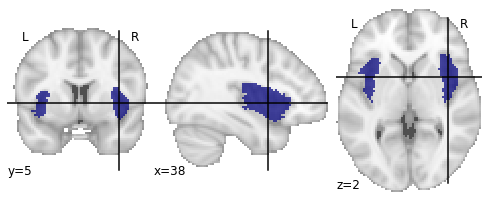

In [3]:
# load mask
mask_file = 'insula_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=8", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)
plt.savefig('InsulaMask.eps',format='eps')

# create a masker 
fwhm = 4
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               sessions=None, smoothing_fwhm=fwhm, standardize=False, 
                                        detrend=False, verbose=5)

In [4]:
#us_cond = '/media/Data/work/RCF_FSLNoScrub/Sink_respNOScrub/1stLevel/_subject_id_{sub}/_modelestimate0/results/cope{cope_num}.nii.gz'
us_cond = '/media/Data/work/RCF_FSLNoScrub/Sink_respNOScrub/1stLevel/_subject_id_{sub}/_modelestimate0/results/zstat{cope_num}.nii.gz'
cope_num =  4#taking shock vs. noshock


In [5]:
us = []
timeseriesIns = []
counter = 1 # set counter to give percentage of progress
for sub in subject_list:
   # try:
    func = us_cond.format(sub=sub, cope_num= cope_num)
    print(func)
    sub = func.split('id_')[1].split('/')[0]
    print(sub)
    print(f'\nFinished {counter/len(subject_list)*100}% of subjects')
    counter = counter +1 
    # amygdala
    tArr = masker.fit_transform(func)
    meanT = np.mean(tArr,axis=1)
    sem = scipy.stats.sem(tArr, axis=1)
    std = np.std(tArr, axis=1)
    

    # create datafram for the timeseries
    dfTS = {'subject':sub, 'ts':tArr[0]}
    # create dataframe for the mean activation
    df = {'subject':sub, 'insula':meanT[0], 'ins_sem':sem[0], 'ins_std':std[0]}
    #df['subject'] = sub
    us.append(df)
    timeseriesIns.append(dfTS)
    #except:
     #   print(f'Subject {sub} has no data')
ins_ud = pd.DataFrame(us)
tsDf = pd.DataFrame(timeseriesIns)

/media/Data/work/RCF_FSLNoScrub/Sink_respNOScrub/1stLevel/_subject_id_029/_modelestimate0/results/zstat4.nii.gz
029

Finished 2.272727272727273% of subjects
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
/media/Data/work/RCF_FSLNoScrub/Sink_respNOScrub/1stLevel/_subject_id_040/_modelestimate0/results/zstat4.nii.gz
040

Finished 4.545454545454546% of subjects
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loa

In [6]:
ins_ud.head()

,subject,insula,ins_sem,ins_std
0,029,1.260520,0.013352,0.761747
1,040,0.383840,0.014056,0.801934
2,1074,0.910831,0.012686,0.723780
3,1205,0.342505,0.013114,0.748188
4,1223,0.912309,0.015730,0.897455


## look at group differences

In [7]:
groupDF = pd.read_csv('groups.csv')
groupDF['subject'] = groupDF['subject'].astype(int).astype(str)
for i in groupDF.iterrows():
    # change two numbers to three
    if len(i[1].subject) < 4:
        groupDF.at[i[0],'subject'] = '0' + i[1].subject


groupDF.head()

,group,subject
0,PTSD,035
1,CC,011
2,PTSD,040
3,PTSD,029
4,CC,020


In [8]:
groupDF.groupby(['group']).count()

,subject
group,
CC,26
PTSD,27


In [9]:
# merge group and stimulus data
dfAll = pd.merge(groupDF, ins_ud)
dfAll.head()

,group,subject,insula,ins_sem,ins_std
0,PTSD,040,0.383840,0.014056,0.801934
1,PTSD,029,1.260520,0.013352,0.761747
2,CC,020,0.526881,0.012479,0.711935
3,CC,1072,1.162193,0.012536,0.715195
4,PTSD,1074,0.910831,0.012686,0.723780


<AxesSubplot:title={'center':'Insula'}, xlabel='group', ylabel='insula'>

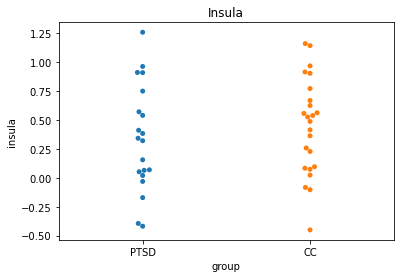

In [10]:
# Plot barplot to see differences
plt.title("Insula")
#sns.barplot(x="group", y="amygdala", data=dfAll, ci=68)
sns.swarmplot(x="group", y="insula", data=dfAll)#, ci=68)

In [11]:
# run simple one-tailed t-test
t = scipy.stats.ttest_ind(dfAll['insula'][dfAll['group']=='CC'],dfAll['insula'][dfAll['group']=='PTSD'], 
                     equal_var = True)

# one tailed
t[1] /2

0.20133237624223743

## Use STAN to check differences

In [12]:
#To select rows whose column value is in list 
groups = ["CC", "PTSD"]
dg = dfAll[dfAll.group.isin(groups)]

# changing group to numbers before we run stan model
group = {'CC': 0,'PTSD': 1} 
dg.group = [group[item] for item in dg.group] 
dg.head()

,group,subject,insula,ins_sem,ins_std
0,1,040,0.383840,0.014056,0.801934
1,1,029,1.260520,0.013352,0.761747
2,0,020,0.526881,0.012479,0.711935
3,0,1072,1.162193,0.012536,0.715195
4,1,1074,0.910831,0.012686,0.723780


In [13]:
# how many in each group
dg.groupby(['group']).count()

,subject,insula,ins_sem,ins_std
group,,,,
0,24,24,24,24
1,20,20,20,20


In [39]:
data =  {'N': len(dg), 'x': dg['group'].values, 'y': dg['insula'].values}
sm = cmdstanpy.CmdStanModel(stan_file='Stan_model/simple_model.stan')


In [40]:
# Train the model and generate samples
seed = 1335 # set random seed
fit_simple_model = sm.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  seed = seed
  #inits = 0.2,
)

In [41]:
#fit
fit_simple_model.summary(percentiles=(4.5,95.5))

,Mean,MCSE,StdDev,4.5%,95.5%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,
lp__,13.00,0.032,1.300,10.00,14.00,1600.0,18000.0,1.0
alpha,0.44,0.002,0.092,0.28,0.59,2100.0,24000.0,1.0
beta,-0.10,0.003,0.140,-0.35,0.12,2100.0,23000.0,1.0
sigma,0.45,0.001,0.051,0.37,0.54,2400.0,28000.0,1.0


In [17]:
# # Extracting traces
alpha = fit_simple_model.stan_variable(name='alpha')
beta = fit_simple_model.stan_variable(name='beta')
sigma = fit_simple_model.stan_variable(name='sigma')
#lp = fit_simple_model.stan_variable(name='lp')

In [18]:
np.percentile(beta, [4.5, 95.5])

array([-0.33681827,  0.12836644])

0.20999999999999996

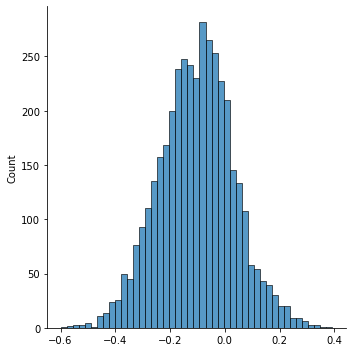

In [19]:
sns.displot(beta)
1 - sum(beta<0) / len(beta)

# Check correlation between amg and behavior

In [20]:
dfPCL = pd.read_csv('pclScores.csv')
# remove the RCF from beginning of subject id
dfPCL['subject'] = dfPCL['subject'].astype(str)
# because some subjects has two digits, we add zero
for i in dfPCL.iterrows():
    if len(i[1].subject) < 4:
        dfPCL.at[i[0],'subject'] = '0' + i[1].subject

dfPCL.head()

,group,subject,pcl_An,pcl_Av,pcl_total
0,PTSD,035,7.0,6.0,43.0
1,CC,011,0.0,0.0,0.0
2,PTSD,040,5.0,4.0,24.0
3,PTSD,029,0.0,1.0,11.0
4,CC,020,0.0,0.0,0.0


In [21]:
## Add BDI as well
dfBDI = pd.read_csv('behavioural/ReconsolidationOfFea_DATA_2021-10-26_1335.csv')
dfBDI.head()

,subject_id,redcap_event_name,bdi_1_sadness,bdi_2_pessimism,bdi_3_pastfailure,bdi_4_pleasure,bdi_5_guilt,bdi_6_punishment,bdi_7_selfdislike,bdi_8_selfcriticalness,...,bdi_13_indecisiveness,bdi_14_worthlessness,bdi_15_lossenergy,bdi_16_sleep,bdi_17_irritability,bdi_18_appetite,bdi_19_concentration,bdi_20_fatigue,bdi_21_sex,bdiii_complete
0,RCF020,self_reports_arm_1,0,0,0,0,0,0.0,0,0,...,0,0,1,2.0,0,0.0,1,1,1,2
1,RCF029,self_reports_arm_1,0,0,0,0,0,0.0,0,0,...,0,0,0,0.0,0,0.0,0,0,0,2
2,RCF040,self_reports_arm_1,1,2,2,2,2,2.0,2,2,...,1,2,1,1.0,2,0.0,2,1,1,2
3,RCF1072,self_reports_arm_1,0,1,0,1,0,0.0,1,0,...,0,0,1,2.0,0,1.0,0,1,0,2
4,RCF1074,self_reports_arm_1,2,2,0,2,2,0.0,1,1,...,1,1,1,4.0,1,2.0,2,2,1,2


In [22]:

sumBDI = np.sum(dfBDI.iloc[:,2:23], axis=1) # sum BDI scores
sumBDI
dfBDI['sum_bdi'] = sumBDI
dfBDI = dfBDI[['subject_id', 'sum_bdi']]

for i in dfBDI.iterrows():
    #print(i[1].subject_id)
    sub = i[1].subject_id.split('RCF')[1]
  #  print(sub)
    dfBDI.at[i[0], 'subject_id'] = sub
  
dfBDI.head()

,subject_id,sum_bdi
0,020,6.0
1,029,1.0
2,040,31.0
3,1072,8.0
4,1074,29.0


In [23]:
groups = ["CC", "PTSD"]
dfpcl_ins = pd.merge(dfPCL, ins_ud)
dfpcl_ins = dfpcl_ins[dfpcl_ins.group.isin(groups)]
dfpcl_ins.head()

,group,subject,pcl_An,pcl_Av,pcl_total,insula,ins_sem,ins_std
0,PTSD,040,5.0,4.0,24.0,0.383840,0.014056,0.801934
1,PTSD,029,0.0,1.0,11.0,1.260520,0.013352,0.761747
2,CC,020,0.0,0.0,0.0,0.526881,0.012479,0.711935
3,CC,1072,1.0,0.0,14.0,1.162193,0.012536,0.715195
4,PTSD,1074,9.0,6.0,54.0,0.910831,0.012686,0.723780


In [24]:
# add sum bdi
dfpcl_ins_bdi = pd.merge(dfpcl_ins, dfBDI, left_on='subject', right_on='subject_id')
dfpcl_ins_bdi.head()

,group,subject,pcl_An,pcl_Av,pcl_total,insula,ins_sem,ins_std,subject_id,sum_bdi
0,PTSD,040,5.0,4.0,24.0,0.383840,0.014056,0.801934,040,31.0
1,PTSD,029,0.0,1.0,11.0,1.260520,0.013352,0.761747,029,1.0
2,CC,020,0.0,0.0,0.0,0.526881,0.012479,0.711935,020,6.0
3,CC,1072,1.0,0.0,14.0,1.162193,0.012536,0.715195,1072,8.0
4,PTSD,1074,9.0,6.0,54.0,0.910831,0.012686,0.723780,1074,29.0


## generate publication plots

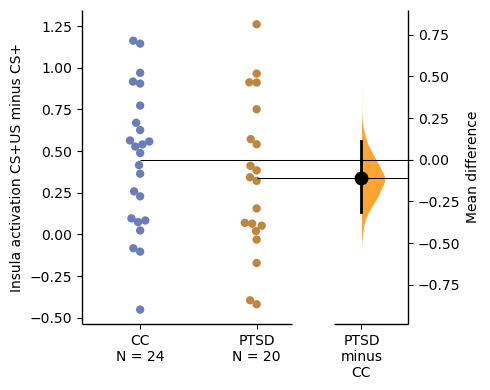

In [25]:
import dabest
groups = ["CC", "PTSD"]
dgr = dfAll[dfAll.group.isin(groups)]

# load our data to dabest to produce graphs
dgr = dgr.rename(columns={"insula": "Insula activation CS+US minus CS+", "group": "Group"})
dgr_dabest = dabest.load(data=dgr, x='Group', y='Insula activation CS+US minus CS+', 
                                  idx=('CC','PTSD'), ci=89)
g1 = dgr_dabest.mean_diff.plot(custom_palette={'CC':'royalblue','PTSD':'darkorange'})
g1.savefig('cleanData_RCF_Insula.png', dpi=300, bbox_inches="tight")

## Robust regression using Stan

In [45]:
data =  {'N': len(dfpcl_ins), 'x': dfpcl_ins['insula'].values, 'y': dfpcl_ins['pcl_An'].values}
sm_robust = cmdstanpy.CmdStanModel(stan_file='Stan_model/robust_reg.stan')


In [46]:
seedRubost = 156 # seed
fit_robust_reg = sm_robust.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  seed = seedRubost
  #inits = 0.2,
)

In [47]:
fit_robust_reg.summary(percentiles=(4.5,95.5))

,Mean,MCSE,StdDev,4.5%,95.5%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,
lp__,-93.0,0.053,1.50,-96.0,-91.00,800.0,4600.0,1.0
alpha,4.0,0.019,0.77,2.7,5.30,1700.0,10000.0,1.0
beta,-1.3,0.032,1.30,-3.6,0.89,1800.0,10000.0,1.0
sigma,3.5,0.010,0.43,2.8,4.30,1700.0,10000.0,1.0
nu,22.0,0.600,14.00,5.9,50.00,560.0,3200.0,1.0


In [32]:
alpha = fit_robust_reg.stan_variable(name='alpha')
beta = fit_robust_reg.stan_variable(name='beta')

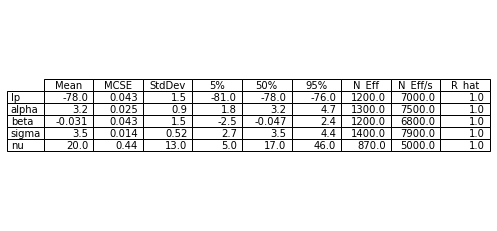

In [34]:
## Create a table
df_fit = fit_robust_reg.summary()
plt.rcParams["figure.figsize"] = [8, 4]
fig, ax =plt.subplots(1,1)
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df_fit.values,colLabels=df_fit.columns,
         rowLabels=["lp_","alpha","beta", "sigma", "nu"],loc="center")
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


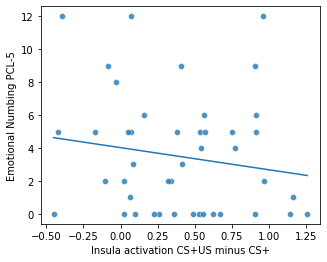

In [33]:
# plot a line based on the robust regression
plt.figure(figsize=(5,4))
line = np.mean(alpha) + np.mean(beta)*dfpcl_ins.insula
fgrid = sns.scatterplot(y='pcl_An', x='insula',data=dfpcl_ins, alpha=0.8)
#plt.plot(dfpcl_amg.amygdala, line)#,alpha = 0.8)
sns.lineplot(dfpcl_ins.insula, line)
fgrid.set(ylabel='Emotional Numbing PCL-5', xlabel='Insula activation CS+US minus CS+')
plt.savefig('RCF_robustRegressionInsula.png', dpi=300, bbox_inches="tight")

## BDI scores

In [34]:
data =  {'N': len(dfpcl_ins_bdi), 'x': dfpcl_ins_bdi['insula'].values, 'y': dfpcl_ins_bdi['sum_bdi'].values}
sm_robust = cmdstanpy.CmdStanModel(stan_file='Stan_model/robust_reg.stan')


In [35]:
seedRubost = 156 # seed
fit_robust_regBDI = sm_robust.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  seed = seedRubost
  #inits = 0.2,
)

In [36]:
fit_robust_regBDI.summary(percentiles=(4.5,95.5))

,Mean,MCSE,StdDev,4.5%,95.5%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,
lp__,-130.0,0.047,1.5,-130.0,-120.0,1100.0,4500.0,1.0
alpha,11.0,0.072,2.9,6.2,16.0,1600.0,6800.0,1.0
beta,1.6,0.110,4.6,-6.4,9.2,1700.0,7300.0,1.0
sigma,13.0,0.050,1.9,9.9,16.0,1400.0,6000.0,1.0
nu,20.0,0.470,14.0,4.6,47.0,820.0,3500.0,1.0


In [37]:
alpha = fit_robust_regBDI.stan_variable(name='alpha')
beta = fit_robust_regBDI.stan_variable(name='beta')

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


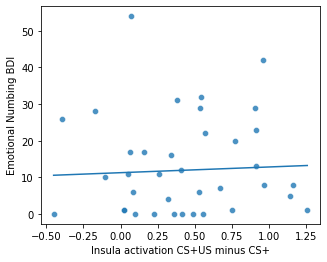

In [38]:
plt.figure(figsize=(5,4))
line = np.mean(alpha) + np.mean(beta)*dfpcl_ins_bdi.insula
fgrid = sns.scatterplot(y='sum_bdi', x='insula',data=dfpcl_ins_bdi, alpha=0.8)
#plt.plot(dfpcl_amg.amygdala, line)#,alpha = 0.8)
sns.lineplot(dfpcl_ins_bdi.insula, line)
fgrid.set(ylabel='Emotional Numbing BDI', xlabel='Insula activation CS+US minus CS+')
plt.savefig('RCF_robustRegressionInsula_BDI.png', dpi=300, bbox_inches="tight")